## K-means clustering


This notebook use K-means clustering to cluster different users 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Load Data

In [2]:
cities_years = {
    'London': [2018, 2019, 2020],
    'Los_Angeles': [2018, 2019, 2020],
    'San_Francisco': [2018, 2019, 2020],
}

import seaborn as sns
cities_colors = {
    'London': sns.color_palette("Blues", n_colors = 3),
    'Los_Angeles': sns.color_palette("Reds", n_colors = 3),
    'San_Francisco': sns.color_palette("Greens", n_colors = 3),
}

In [3]:
from collections import defaultdict
dfs = defaultdict(dict)
dfall = []

for city, years in cities_years.items():
    for year in years:
        print("Loading: ", city, year)
        df = pd.read_csv("../data/raw/observations_v2/CNC_{}_{}.csv".format(city, year))
        dfs[city][year] = df
        dfall.append(df)

dfall = pd.concat(dfall)
dfs['London'][2018].head()

Loading:  London 2018
Loading:  London 2019
Loading:  London 2020
Loading:  Los_Angeles 2018
Loading:  Los_Angeles 2019
Loading:  Los_Angeles 2020
Loading:  San_Francisco 2018
Loading:  San_Francisco 2019
Loading:  San_Francisco 2020


,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11479007,2018-04-27 7:52:34 am BST,2018-04-27T07:52:34+00:00,Etc/UTC,2018-04-27T07:06:17+00:00,2018-04-27T09:26:56+00:00,NaN,159021,muki,research,...,lesser celandine,Plantae,species,204212,True,False,False,26862,26862,"[{'user_id': 353381, 'category': 'improving', ..."
1,11480212,2018-04-27 8:39:41 am BST,2018-04-27T08:39:41+01:00,Europe/London,2018-04-27T09:02:52+01:00,2019-01-29T21:16:34+00:00,NaN,664459,lucyrobinsonnhm,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,38831,38831,"[{'user_id': 29729, 'category': 'supporting', ..."
2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27T08:34:31+02:00,Europe/Amsterdam,2018-04-27T10:42:01+02:00,2018-04-27T13:01:49+02:00,NaN,908315,tess26,casual,...,Spanish Bluebell,Plantae,species,56095,False,False,False,2801,2801,"[{'user_id': 908315, 'category': 'leading', 'd..."
3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27T09:54:35+02:00,Europe/Amsterdam,2018-04-27T10:54:45+02:00,2018-04-27T22:23:41+02:00,NaN,796473,bryonycross,research,...,Green Alkanet,Plantae,species,156638,False,False,False,4509,4509,"[{'user_id': 160, 'category': 'improving', 'di..."
4,11482247,2018-04-27 8:42:21 am BST,2018-04-27T08:42:21+01:00,Europe/London,2018-04-27T11:09:55+01:00,2018-04-27T16:37:31+01:00,NaN,664459,lucyrobinsonnhm,research,...,London Plane,Plantae,hybrid,49664,False,False,False,5475,5475,"[{'user_id': 160, 'category': 'supporting', 'd..."


In [4]:
lon_2018 = dfs['London'][2018]
lon_2018

,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11479007,2018-04-27 7:52:34 am BST,2018-04-27T07:52:34+00:00,Etc/UTC,2018-04-27T07:06:17+00:00,2018-04-27T09:26:56+00:00,NaN,159021,muki,research,...,lesser celandine,Plantae,species,204212,True,False,False,26862,26862,"[{'user_id': 353381, 'category': 'improving', ..."
1,11480212,2018-04-27 8:39:41 am BST,2018-04-27T08:39:41+01:00,Europe/London,2018-04-27T09:02:52+01:00,2019-01-29T21:16:34+00:00,NaN,664459,lucyrobinsonnhm,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,38831,38831,"[{'user_id': 29729, 'category': 'supporting', ..."
2,11480902,Fri Apr 27 2018 08:34:31 GMT+0100 (GMT+1),2018-04-27T08:34:31+02:00,Europe/Amsterdam,2018-04-27T10:42:01+02:00,2018-04-27T13:01:49+02:00,NaN,908315,tess26,casual,...,Spanish Bluebell,Plantae,species,56095,False,False,False,2801,2801,"[{'user_id': 908315, 'category': 'leading', 'd..."
3,11481097,Fri Apr 27 2018 09:54:35 GMT+0100 (GMT+1),2018-04-27T09:54:35+02:00,Europe/Amsterdam,2018-04-27T10:54:45+02:00,2018-04-27T22:23:41+02:00,NaN,796473,bryonycross,research,...,Green Alkanet,Plantae,species,156638,False,False,False,4509,4509,"[{'user_id': 160, 'category': 'improving', 'di..."
4,11482247,2018-04-27 8:42:21 am BST,2018-04-27T08:42:21+01:00,Europe/London,2018-04-27T11:09:55+01:00,2018-04-27T16:37:31+01:00,NaN,664459,lucyrobinsonnhm,research,...,London Plane,Plantae,hybrid,49664,False,False,False,5475,5475,"[{'user_id': 160, 'category': 'supporting', 'd..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,12414445,Sun Apr 29 2018 13:05:02 GMT+0100 (GMT+1),2018-04-29T13:05:02+02:00,Europe/Amsterdam,2018-05-13T16:59:09+02:00,2020-06-07T17:05:10+02:00,On an old brick wall,959280,maaz,casual,...,Garden Tulip,Plantae,species,55800,False,False,False,5297,5297,"[{'user_id': 662980, 'category': 'improving', ..."
2620,12482715,Fri Apr 27 2018 16:02:46 GMT+0100 (GMT+1),2018-04-27T16:02:46+02:00,Europe/Amsterdam,2018-05-15T17:44:31+02:00,2018-05-15T18:04:56+02:00,On an old brick wall,963377,nebula104,research,...,common hawthorn,Plantae,species,51148,True,False,False,17686,17686,"[{'user_id': 963377, 'category': 'improving', ..."
2621,12953188,2018-04-28 8:54:00 p.m. BST,2018-04-28T20:54:00+00:00,Etc/UTC,2018-05-30T14:39:30+00:00,2018-06-24T20:25:34+00:00,"Heard using a bat detector in Hyde Park, Londo...",765950,sashapratttaweh,casual,...,Common Pipistrelle,Mammalia,species,40355,True,False,False,785,785,"[{'user_id': 765950, 'category': 'improving', ..."
2622,30378646,Sat Apr 28 2018 18:20:55 GMT+0100 (GMT+1),2018-04-28T18:20:55+02:00,Europe/Amsterdam,2019-08-07T20:43:35+02:00,2019-08-08T09:45:13+02:00,"Heard using a bat detector in Hyde Park, Londo...",2089713,suedawson,research,...,Feral Pigeon,Aves,variety,3017,False,False,False,38831,38831,"[{'user_id': 2089713, 'category': 'maverick', ..."


# Calculate participation

## Get number of observations and identifications

In [5]:
def get_obs_idents_per_user(dfcity):
    """ Calculate the number of observations and identifications per user 
    
    Input:
    ------
     - dfcity: pd.DataFrame
         The observations data for one city.
    
    Returns:
    -------
     - dfobsident: pd.DataFrame
         Has the columns: user_id | n_obs | n_idents
    
    """
    from collections import defaultdict
    n_obs = defaultdict(int)
    n_idents = defaultdict(int)


    for _, row in dfcity.iterrows():
        # Count observation to user that observed
        user_obs = row['user_id']
        n_obs[user_obs] += 1

        # Count identications the user did
        identifications = eval(row['identifications'])
        for ident in identifications:
            user_ident = ident['user_id']
            if user_ident != user_obs:
                n_idents[user_ident] += 1
    # Create dataframe with observations, identifications
    dfobsident = pd.DataFrame([n_obs, n_idents]).T.reset_index().convert_dtypes().fillna(0)
    dfobsident.columns = ['user_id', 'n_obs', 'n_idents']
    dfobsident
    return dfobsident

## London 2018

In [7]:
dfcity = dfs['London'][2018]
london_2018 = get_obs_idents_per_user(dfcity)
london_2018.head()

,user_id,n_obs,n_idents
0,159021,21,0
1,664459,150,55
2,908315,3,0
3,796473,26,1
4,903018,34,0


In [11]:
dfcity = dfs['London'][2018]
lon_2018 = get_obs_idents_per_user(dfcity)
lon_2018

,user_id,n_obs,n_idents
0,159021,21,0
1,664459,150,55
2,908315,3,0
3,796473,26,1
4,903018,34,0
...,...,...,...
406,270500,0,3
407,927911,0,1
408,661392,0,1
409,2567895,0,1


In [12]:
#test user 160
u160_2018 = lon_2018.loc[lon_2018['user_id']==160]
u160_2018

,user_id,n_obs,n_idents
110,160,0,524


In [13]:
print(lon_2018.shape)
print(lon_2018.dtypes)

(411, 3)
user_id     Int64
n_obs       Int64
n_idents    Int64
dtype: object


In [14]:
lon_2018.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,411.0,890377.746959,682878.431436,1.0,396410.5,863566.0,1090045.0,3270248.0
n_obs,411.0,6.384428,32.236597,0.0,0.0,0.0,1.0,567.0
n_idents,411.0,7.289538,30.813544,0.0,1.0,1.0,4.0,524.0


In [15]:
#log transform
#step before log transformation to avoid the zeros 
lon_2018['obs_count_1']=lon_2018['n_obs']+1
lon_2018['ident_count_1']=lon_2018['n_idents']+1

In [16]:
#log transform
lon_2018['obs_count_log'] = np.log(lon_2018['obs_count_1'])
lon_2018['ident_count_log'] = np.log(lon_2018['ident_count_1'])

In [17]:
lon_2018.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
291,1,0,1,1,2,0.0,0.693147
110,160,0,524,1,525,0.0,6.263398
176,351,0,9,1,10,0.0,2.302585
356,462,0,1,1,2,0.0,0.693147
188,477,0,6,1,7,0.0,1.94591


In [18]:
#select varibles for plotting
df_select = lon_2018[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std = df_select.copy()

In [19]:
#Don't include the user_id column in the transformation:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [20]:
#assign the result to those two columns
df_std[col_names] = features
df_std.rename(columns={'obs_count_log': 'obs_count_2018', 'ident_count_log': 'ident_count_2018'}, inplace=True)
df_std.sort_values('user_id')
#print(df_std)

,user_id,obs_count_2018,ident_count_2018
291,1,-0.491271,-0.451473
110,160,-0.491271,4.782888
176,351,-0.491271,1.060915
356,462,-0.491271,-0.451473
188,477,-0.491271,0.725748
...,...,...,...
252,3028032,-0.491271,-0.451473
400,3059808,-0.491271,-0.451473
192,3113652,-0.491271,0.199877
274,3236772,-0.491271,-0.070457


In [21]:
#define cololor 
color_dict = {'high activity':'red',
              'identifiers':'blue',
              'observers':'green',
              'low activity':'orange'}

In [22]:
label_dict = {0:'high activity', 1:'identifiers', 2:'observers',3:'low activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std[['obs_count_2018',
                                                                        'ident_count_2018']])
df_std['cluster_2018'] = kmeans.labels_
df_std['user_type2018'] = [label_dict.get(i) for i in df_std.cluster_2018]
df_std.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018
291,1,-0.491271,-0.451473,3,low activity
110,160,-0.491271,4.782888,1,identifiers
176,351,-0.491271,1.060915,1,identifiers
356,462,-0.491271,-0.451473,3,low activity
188,477,-0.491271,0.725748,1,identifiers
...,...,...,...,...,...
252,3028032,-0.491271,-0.451473,3,low activity
400,3059808,-0.491271,-0.451473,3,low activity
192,3113652,-0.491271,0.199877,3,low activity
274,3236772,-0.491271,-0.070457,3,low activity


In [23]:
import seaborn


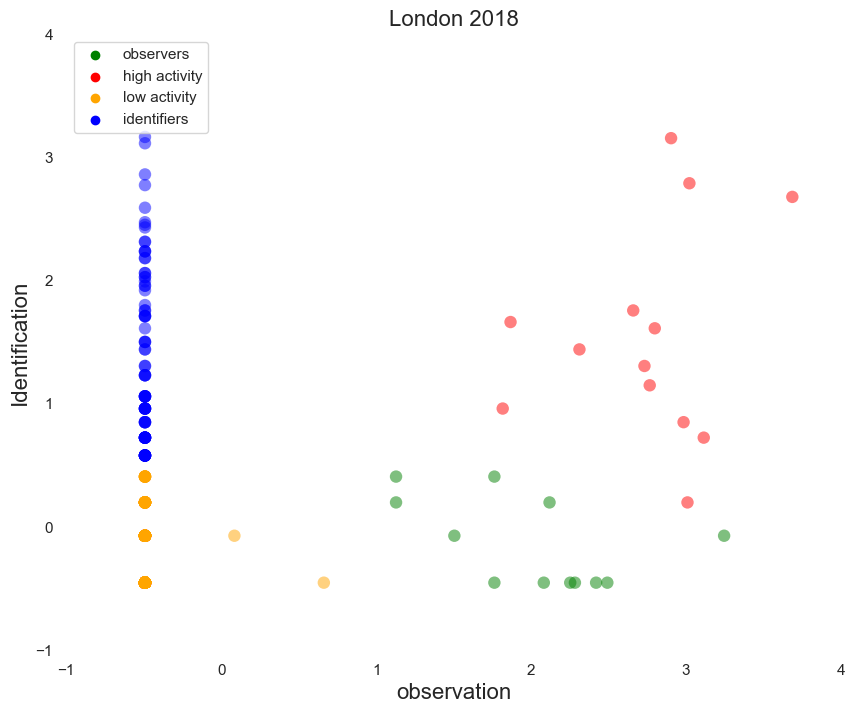

In [24]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(10,8))
ax = plt.axes()
sns.set(style="ticks")
ax = sns.scatterplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018',
                     hue='user_type2018',
                     palette=color_dict,
                     s=80, linewidth=0,alpha=0.5)
#ax.set(yscale="log")
#ax.set(xscale="log")
sns.set_style("ticks")
plt.legend(loc='upper left')
plt.title('London 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

## London 2019

In [25]:
dfcity = dfs['London'][2019]
lon_2019 = get_obs_idents_per_user(dfcity)
lon_2019

,user_id,n_obs,n_idents
0,1595601,7,0
1,1613966,6,0
2,1665840,3,0
3,1624432,29,0
4,1653354,113,65
...,...,...,...
704,1052771,0,1
705,1859910,0,1
706,1754070,0,1
707,175522,0,1


In [26]:
y = lon_2019.loc[lon_2019['user_id']==160]
y

,user_id,n_obs,n_idents
287,160,0,574


In [27]:
#step before log transformation to avoid the zeros 
lon_2019['obs_count_1']=lon_2019['n_obs']+1
lon_2019['ident_count_1']=lon_2019['n_idents']+1

In [28]:
#log transform
lon_2019['obs_count_log'] = np.log(lon_2019['obs_count_1'])
lon_2019['ident_count_log'] = np.log(lon_2019['ident_count_1'])

In [29]:
lon_2019.sort_values('user_id')

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
613,28,0,1,1,2,0.0,0.693147
287,160,0,574,1,575,0.0,6.35437
546,305,0,6,1,7,0.0,1.94591
314,351,0,50,1,51,0.0,3.931826
652,354,0,2,1,3,0.0,1.098612
...,...,...,...,...,...,...,...
359,3374329,0,1,1,2,0.0,0.693147
437,3528800,0,2,1,3,0.0,1.098612
443,3618354,0,2,1,3,0.0,1.098612
568,3638742,0,1,1,2,0.0,0.693147


In [30]:
lon_2019.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
613,28,0,1,1,2,0.0,0.693147
287,160,0,574,1,575,0.0,6.35437
546,305,0,6,1,7,0.0,1.94591
314,351,0,50,1,51,0.0,3.931826
652,354,0,2,1,3,0.0,1.098612


In [27]:
#frames = [lon_2018, lon_2019]
#lon_2019 = pd.concat(frames)
#lon_2019.sort_values('user_id')

In [31]:
#select varibles for plotting
df_select_2019 = lon_2019[['user_id','obs_count_log', 'ident_count_log']]

#create a copy of your dataframe:
df_std_2019 = df_select_2019.copy()
df_std_2019.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
613,28,0.0,0.693147
287,160,0.0,6.35437
546,305,0.0,1.94591
314,351,0.0,3.931826
652,354,0.0,1.098612
...,...,...,...
359,3374329,0.0,0.693147
437,3528800,0.0,1.098612
443,3618354,0.0,1.098612
568,3638742,0.0,0.693147


In [32]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2019[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [33]:
#assign the result to those two columns
df_std_2019[col_names] = features
df_std_2019.rename(columns={'obs_count_log': 'obs_count_2019', 'ident_count_log': 'ident_count_2019'}, inplace=True)
df_std_2019

,user_id,obs_count_2019,ident_count_2019
0,1595601,1.090621,-0.868401
1,1613966,0.980968,-0.868401
2,1665840,0.521423,-0.868401
3,1624432,2.176020,-0.868401
4,1653354,3.272295,2.675247
...,...,...,...
704,1052771,-0.616973,-0.282131
705,1859910,-0.616973,-0.282131
706,1754070,-0.616973,-0.282131
707,175522,-0.616973,-0.282131


In [34]:
label_dict = {0:'observers', 1:'identifiers', 2:'high activity',3:'low activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2019[['obs_count_2019',
                                                                        'ident_count_2019']])
df_std_2019['cluster_2019'] = kmeans.labels_
df_std_2019['user_type2019'] = [label_dict.get(i) for i in df_std_2019.cluster_2019]
df_std_2019.sort_values('user_id')

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
613,28,-0.616973,-0.282131,3,low activity
287,160,-0.616973,4.506183,1,identifiers
546,305,-0.616973,0.777467,3,low activity
314,351,-0.616973,2.457173,1,identifiers
652,354,-0.616973,0.060815,3,low activity
...,...,...,...,...,...
359,3374329,-0.616973,-0.282131,3,low activity
437,3528800,-0.616973,0.060815,3,low activity
443,3618354,-0.616973,0.060815,3,low activity
568,3638742,-0.616973,-0.282131,3,low activity


In [36]:
lowa_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='low activity']
lowa_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
210,1450851,0.285185,0.060815,3,low activity
228,1690758,-0.047775,-0.282131,3,low activity
273,1690105,-0.047775,-0.282131,3,low activity
291,1616421,-0.616973,-0.282131,3,low activity
304,1111376,-0.616973,0.492876,3,low activity
...,...,...,...,...,...
704,1052771,-0.616973,-0.282131,3,low activity
705,1859910,-0.616973,-0.282131,3,low activity
706,1754070,-0.616973,-0.282131,3,low activity
707,175522,-0.616973,-0.282131,3,low activity


In [37]:
ob_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='observers']
ob_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
0,1595601,1.090621,-0.868401,0,observers
1,1613966,0.980968,-0.868401,0,observers
2,1665840,0.521423,-0.868401,0,observers
11,1257486,-0.047775,-0.868401,0,observers
12,1670072,-0.047775,-0.868401,0,observers
...,...,...,...,...,...
279,3026711,-0.047775,-0.868401,0,observers
280,3110080,-0.047775,-0.868401,0,observers
281,3314237,-0.047775,-0.868401,0,observers
282,3366178,-0.047775,-0.868401,0,observers


In [38]:
id_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='identifiers']
id_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
24,1297026,1.273862,2.608614,1,identifiers
32,894051,3.570932,4.660393,1,identifiers
69,885619,2.391468,2.748842,1,identifiers
71,664459,1.550166,3.386389,1,identifiers
107,1589594,0.285185,1.422092,1,identifiers
...,...,...,...,...,...
603,1453,-0.616973,1.363738,1,identifiers
632,205067,-0.616973,0.990031,1,identifiers
655,978746,-0.616973,1.476680,1,identifiers
702,790453,-0.616973,1.950008,1,identifiers


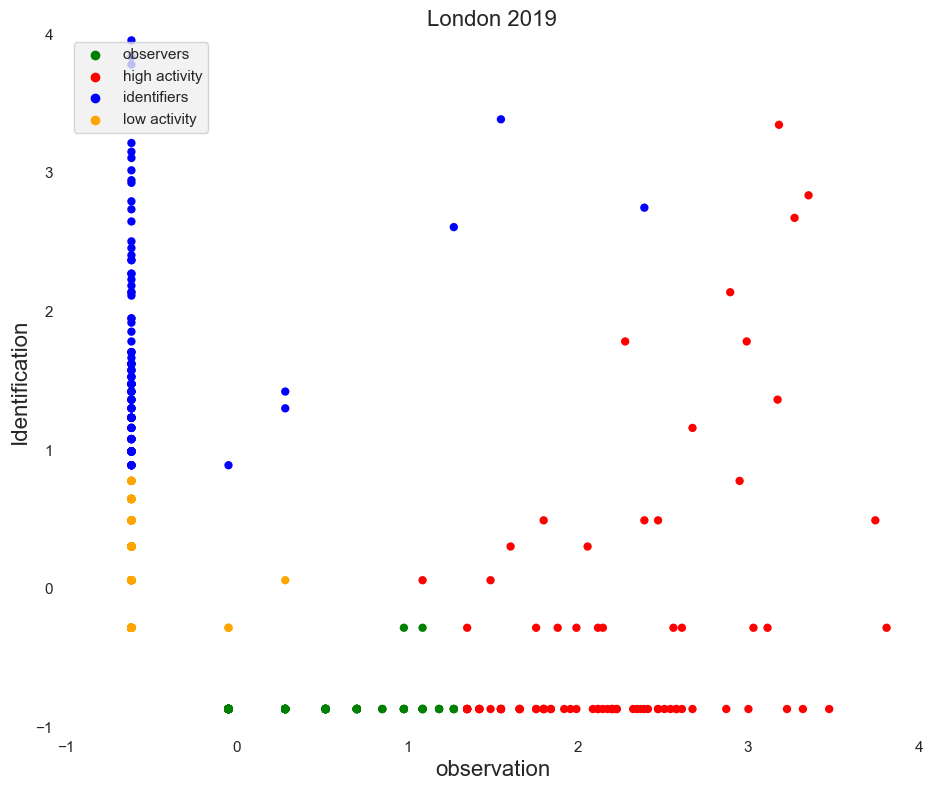

In [35]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019',
                     hue='user_type2019',
                     palette=color_dict,
                     s=36, linewidth=0)
plt.legend(loc='upper left')
plt.title('London 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### merge two dataset 2018 and 2019

In [39]:
df = pd.merge(df_std, df_std_2019, on="user_id", how="right")
df.sort_values('user_id')      

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
613,28,NaN,NaN,NaN,NaN,-0.616973,-0.282131,3,low activity
287,160,-0.491271,4.782888,1.0,identifiers,-0.616973,4.506183,1,identifiers
546,305,NaN,NaN,NaN,NaN,-0.616973,0.777467,3,low activity
314,351,-0.491271,1.060915,1.0,identifiers,-0.616973,2.457173,1,identifiers
652,354,NaN,NaN,NaN,NaN,-0.616973,0.060815,3,low activity
...,...,...,...,...,...,...,...,...,...
359,3374329,NaN,NaN,NaN,NaN,-0.616973,-0.282131,3,low activity
437,3528800,NaN,NaN,NaN,NaN,-0.616973,0.060815,3,low activity
443,3618354,NaN,NaN,NaN,NaN,-0.616973,0.060815,3,low activity
568,3638742,NaN,NaN,NaN,NaN,-0.616973,-0.282131,3,low activity


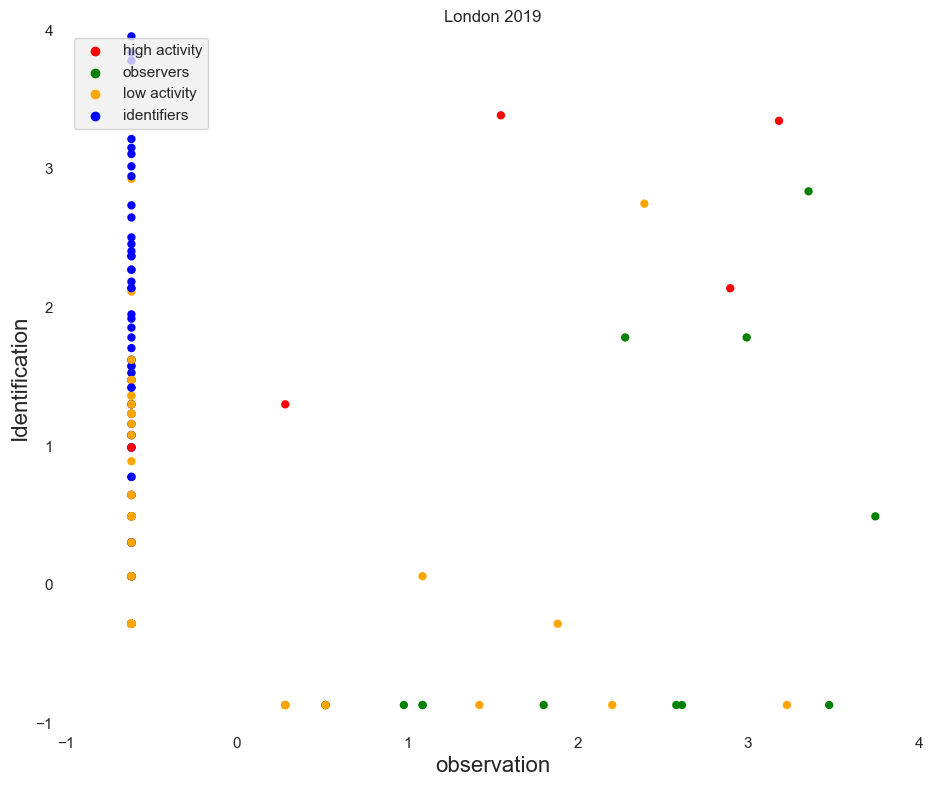

In [40]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)  
ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

plt.legend(loc='upper left')
plt.title('London 2019')
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [41]:
#test 
higha_2019 = df.loc[df['user_type2019']=='high activity']
higha_2019.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019
8,137006,2.311712,1.441930,0.0,high activity,2.894937,2.138745,2,high activity
75,159021,2.081755,-1.102822,2.0,observers,2.611761,-0.868401,2,high activity
10,353381,4.787997,1.150478,0.0,high activity,5.123281,0.777467,2,high activity
139,735917,2.282502,-1.102822,2.0,observers,1.800939,-0.868401,2,high activity
28,781146,3.308155,-1.102822,2.0,observers,3.475461,-0.868401,2,high activity
...,...,...,...,...,...,...,...,...,...
192,1690226,NaN,NaN,NaN,NaN,2.148181,-0.868401,2,high activity
193,1690243,NaN,NaN,NaN,NaN,1.800939,-0.868401,2,high activity
233,1695874,NaN,NaN,NaN,NaN,1.352129,-0.868401,2,high activity
224,1696420,NaN,NaN,NaN,NaN,2.561977,-0.282131,2,high activity


## London 2020

In [42]:
dfcity = dfs['London'][2020]
lon_2020 = get_obs_idents_per_user(dfcity)
lon_2020.sort_values('user_id')

,user_id,n_obs,n_idents
677,1,0,1
707,28,0,3
571,160,0,236
798,305,0,4
597,351,0,28
...,...,...,...
567,3564330,2,0
568,3639007,1,0
569,3673870,1,0
635,3730250,0,1


In [43]:
lon_2020.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,999.0,1.963577e+06,953938.107587,1.0,1233025.5,2249019.0,2827081.0,3809444.0
n_obs,999.0,5.807808e+00,23.219850,0.0,0.0,1.0,3.0,355.0
n_idents,999.0,7.073073e+00,52.923884,0.0,0.0,0.0,2.0,1218.0


In [44]:
lon_2020['obs_count_1']=lon_2020['n_obs']+1
lon_2020['ident_count_1']=lon_2020['n_idents']+1

In [45]:
#log transform
lon_2020['obs_count_log'] = np.log(lon_2020['obs_count_1'])
lon_2020['ident_count_log'] = np.log(lon_2020['ident_count_1'])

In [47]:
lon_2020.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
677,1,0,1,1,2,0.0,0.693147
707,28,0,3,1,4,0.0,1.386294
571,160,0,236,1,237,0.0,5.46806
798,305,0,4,1,5,0.0,1.609438
597,351,0,28,1,29,0.0,3.367296


In [48]:
#checking the user 160 
user_160 = lon_2020.loc[lon_2020['user_id']==160]
user_160

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
571,160,0,236,1,237,0.0,5.46806


In [49]:
#frames1 = [lon_2019, lon_2020]
#lon_2020 = pd.concat(frames1)
#lon_2020.sort_values('user_id')

In [50]:
#select varibles for plotting
df_select_2020 = lon_2020[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std_2020 = df_select_2020.copy()
df_std_2020.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
677,1,0.0,0.693147
707,28,0.0,1.386294
571,160,0.0,5.46806
798,305,0.0,1.609438
597,351,0.0,3.367296
...,...,...,...
567,3564330,1.098612,0.0
568,3639007,0.693147,0.0
569,3673870,0.693147,0.0
635,3730250,0.0,0.693147


In [51]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2020[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [52]:
#assign the result to those two columns
df_std_2020[col_names] = features
df_std_2020.rename(columns={'obs_count_log': 'obs_count_2020', 'ident_count_log': 'ident_count_2020'}, inplace=True)
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020
677,1,-0.794928,-0.040955
707,28,-0.794928,0.607358
571,160,-0.794928,4.425106
798,305,-0.794928,0.816068
597,351,-0.794928,2.460224
...,...,...,...
567,3564330,0.207990,-0.689268
568,3639007,-0.162157,-0.689268
569,3673870,-0.162157,-0.689268
635,3730250,-0.794928,-0.040955


In [53]:
label_dict = {0:'observers', 1:'identifiers', 2:'high activity',3:'low activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2020[['obs_count_2020',
                                                                        'ident_count_2020']])
df_std_2020['cluster_2020'] = kmeans.labels_
df_std_2020['user_type2020'] = [label_dict.get(i) for i in df_std_2020.cluster_2020]
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
677,1,-0.794928,-0.040955,1,identifiers
707,28,-0.794928,0.607358,1,identifiers
571,160,-0.794928,4.425106,2,high activity
798,305,-0.794928,0.816068,1,identifiers
597,351,-0.794928,2.460224,2,high activity
...,...,...,...,...,...
567,3564330,0.207990,-0.689268,3,low activity
568,3639007,-0.162157,-0.689268,3,low activity
569,3673870,-0.162157,-0.689268,3,low activity
635,3730250,-0.794928,-0.040955,1,identifiers


In [54]:
#test
user2020 = df_std_2020.loc[df_std_2020['user_id']==160]
user2020

,user_id,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
571,160,-0.794928,4.425106,2,high activity


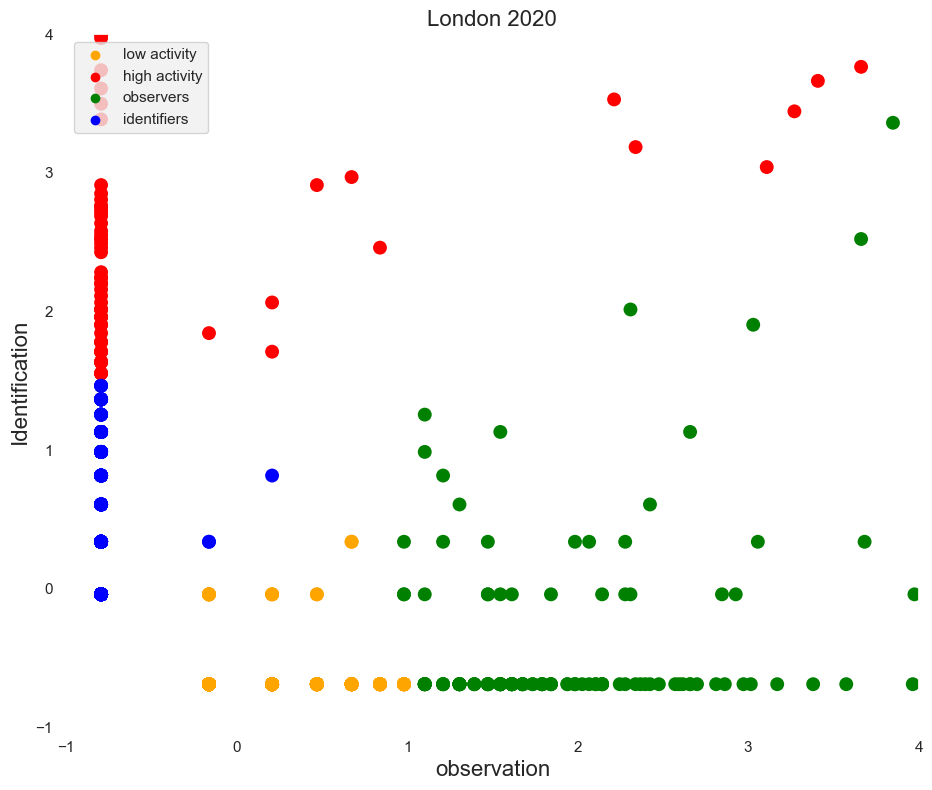

In [55]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020',
                     hue='user_type2020',
                     palette=color_dict,
                     s=100, linewidth=0)
plt.legend(loc='upper left')
plt.title('London 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### Merge 2018,2019 and 2020

In [56]:
df1 = pd.merge(df,df_std_2020, on="user_id", how="right")
df1.sort_values('user_id') 

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
677,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.794928,-0.040955,1,identifiers
707,28,NaN,NaN,NaN,NaN,-0.616973,-0.282131,3.0,low activity,-0.794928,0.607358,1,identifiers
571,160,-0.491271,4.782888,1.0,identifiers,-0.616973,4.506183,1.0,identifiers,-0.794928,4.425106,2,high activity
798,305,NaN,NaN,NaN,NaN,-0.616973,0.777467,3.0,low activity,-0.794928,0.816068,1,identifiers
597,351,-0.491271,1.060915,1.0,identifiers,-0.616973,2.457173,1.0,identifiers,-0.794928,2.460224,2,high activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,3564330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.207990,-0.689268,3,low activity
568,3639007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.162157,-0.689268,3,low activity
569,3673870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.162157,-0.689268,3,low activity
635,3730250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.794928,-0.040955,1,identifiers


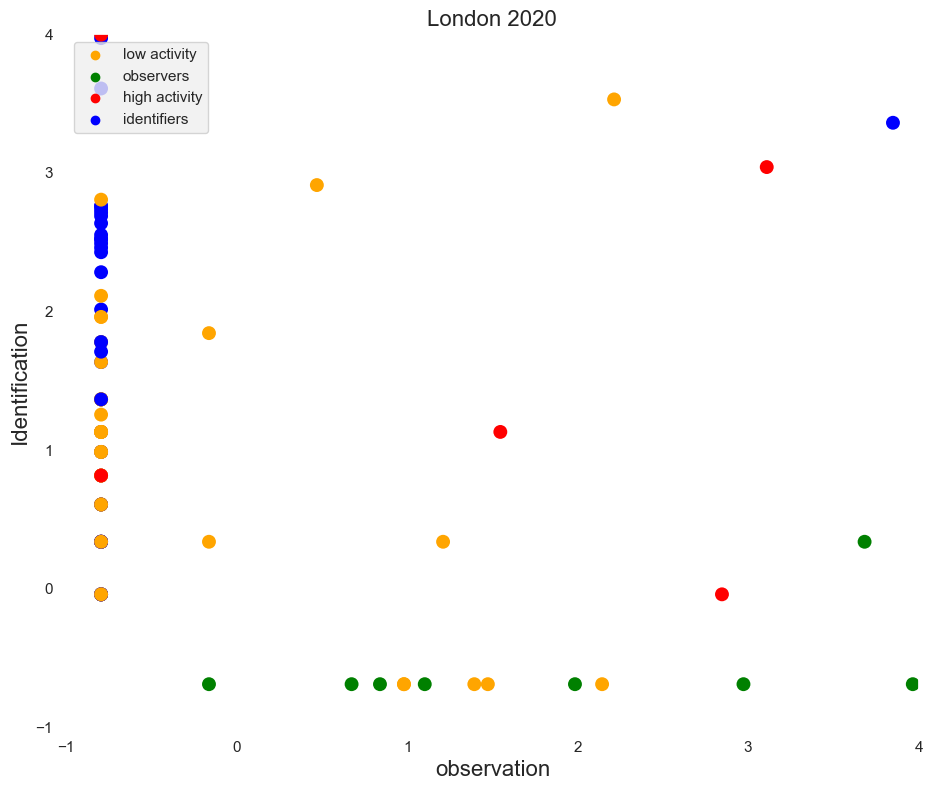

In [58]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)  
ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=100, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('London 2020', fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [59]:
#check user 160 to see different clusters
user = df1.loc[df1['user_id']==160]
user

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
571,160,-0.491271,4.782888,1.0,identifiers,-0.616973,4.506183,1.0,identifiers,-0.794928,4.425106,2,high activity


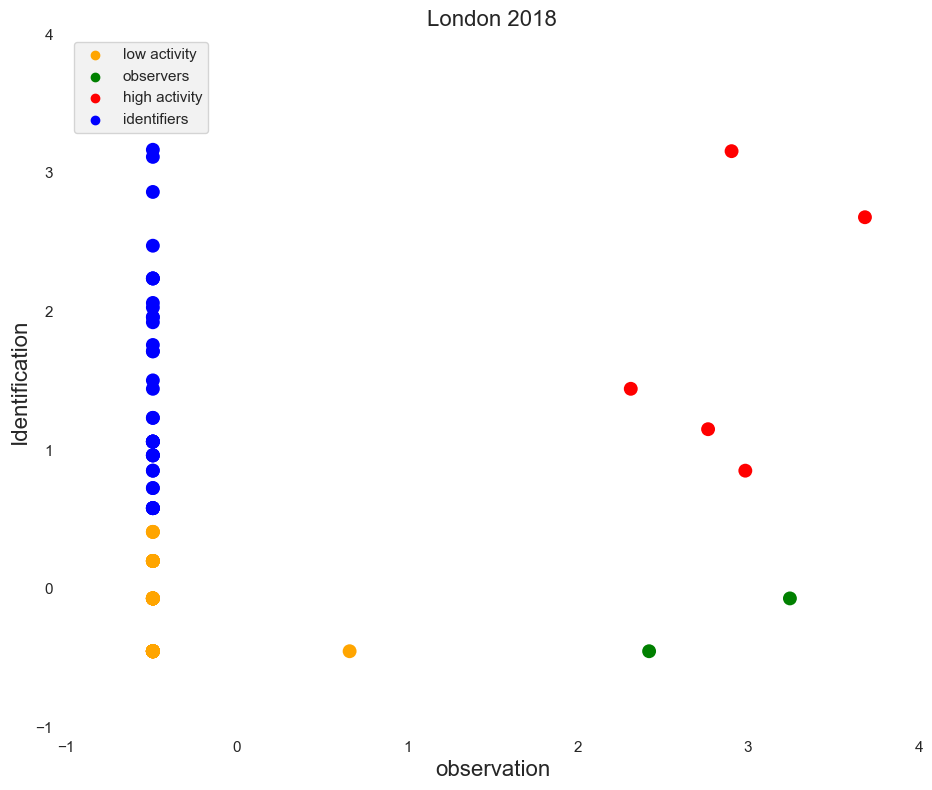

In [60]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('London 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

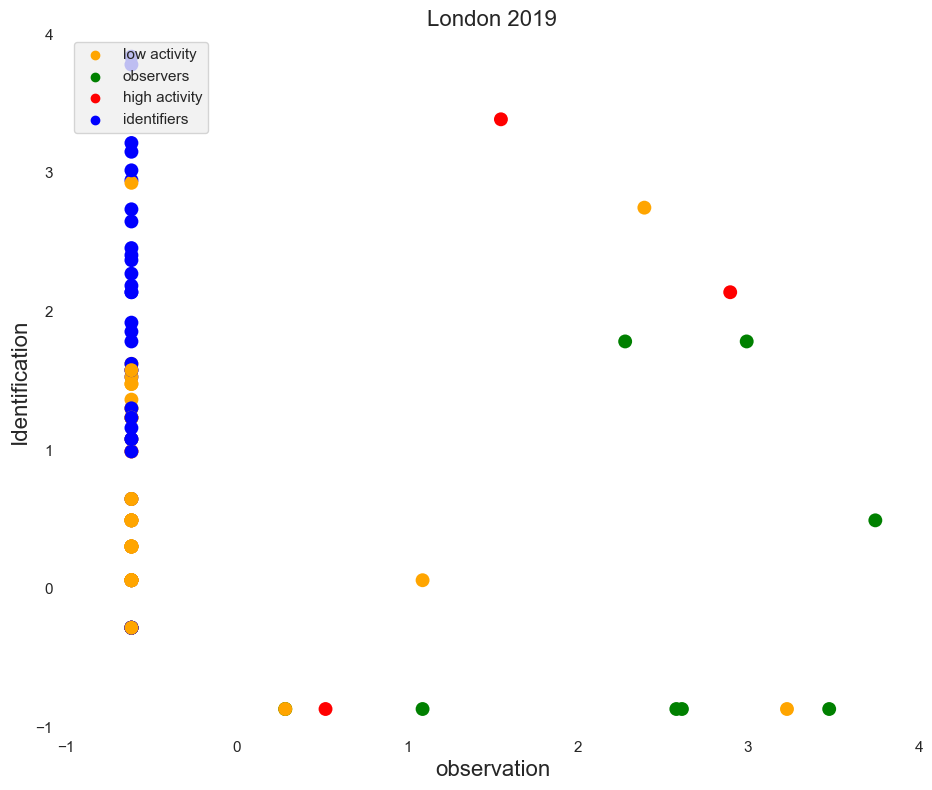

In [61]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))


#ax = ax.add_subplot(gs[1:5,0:3])
ax = sns.scatterplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('London 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

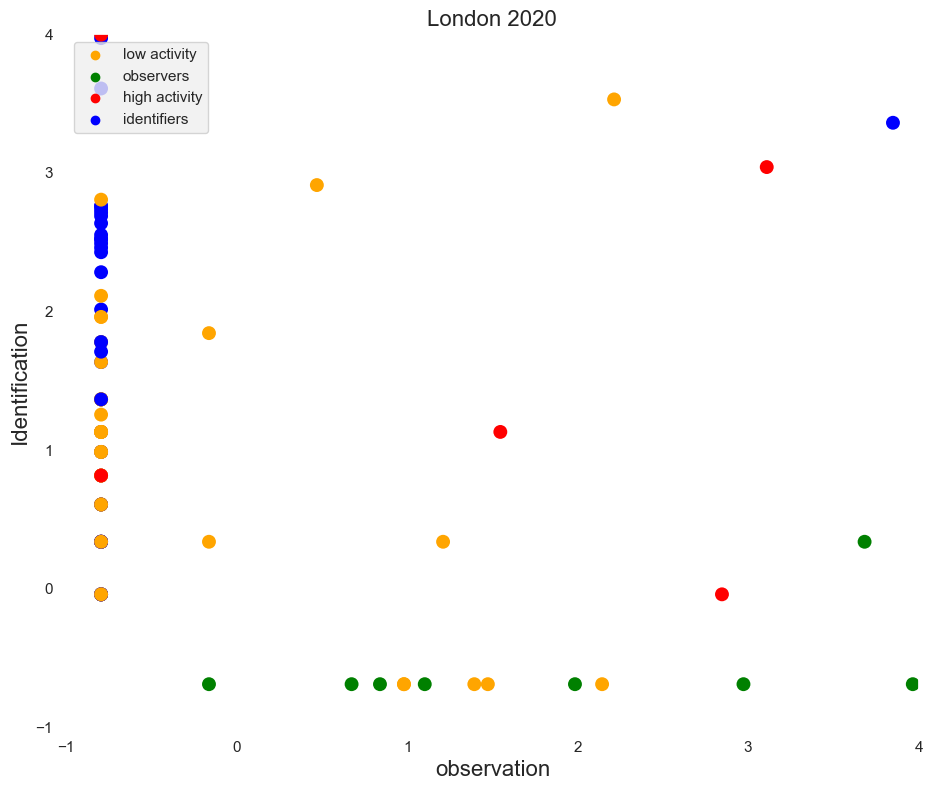

In [62]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',  hue='user_type2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('London 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [63]:
user_160 = df1.loc[df1['user_id']== 160]
user_160

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
571,160,-0.491271,4.782888,1.0,identifiers,-0.616973,4.506183,1.0,identifiers,-0.794928,4.425106,2,high activity


In [69]:
df1.sort_values('user_id')
df1 = df1.drop_duplicates()
df1

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user_type2018,obs_count_2019,ident_count_2019,cluster_2019,user_type2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020
0,2295352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.207990,-0.689268,3,low activity
1,2777317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.162157,-0.689268,3,low activity
2,1653354,NaN,NaN,NaN,NaN,3.272295,2.675247,2.0,high activity,3.662558,3.764878,2,high activity
3,1488476,NaN,NaN,NaN,NaN,3.113886,-0.282131,2.0,high activity,4.568267,5.956900,2,high activity
4,908795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.614255,-0.689268,0,observers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,405954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.794928,-0.040955,1,identifiers
995,1236256,NaN,NaN,NaN,NaN,-0.616973,0.647085,3.0,low activity,-0.794928,-0.040955,1,identifiers
996,1902663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.794928,-0.040955,1,identifiers
997,2541608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.794928,0.338284,1,identifiers


## 2D Contour Plot (Density Plot)

### London 2018 

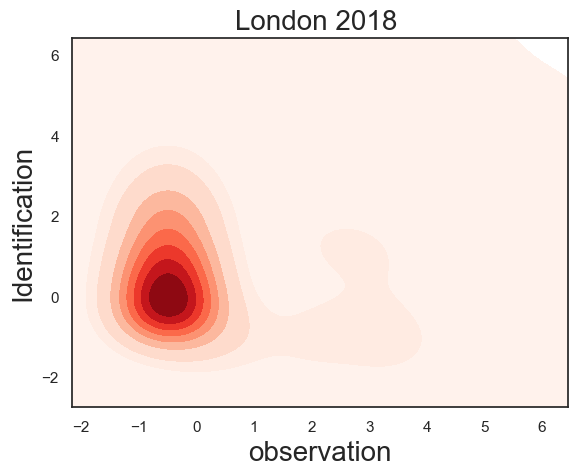

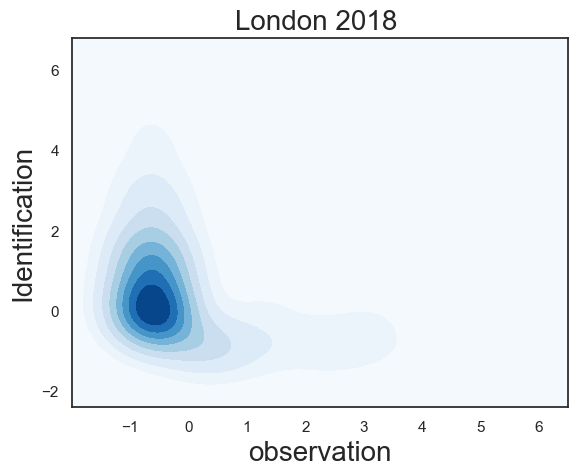

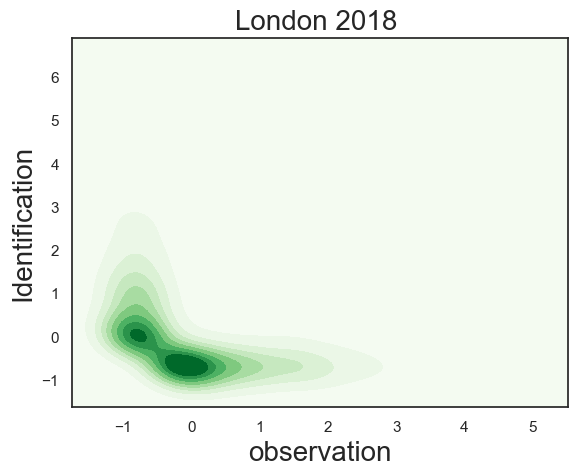

In [74]:
# set seaborn style
sns.set_style("white")

# Add thresh parameter
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Reds", shade=True, thresh=0)
plt.title('London 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()


sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019, cmap="Blues", shade=True, thresh=0)
plt.title('London 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020, cmap="Greens", shade=True, thresh=0)
plt.title('London 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

LinAlgError: singular matrix

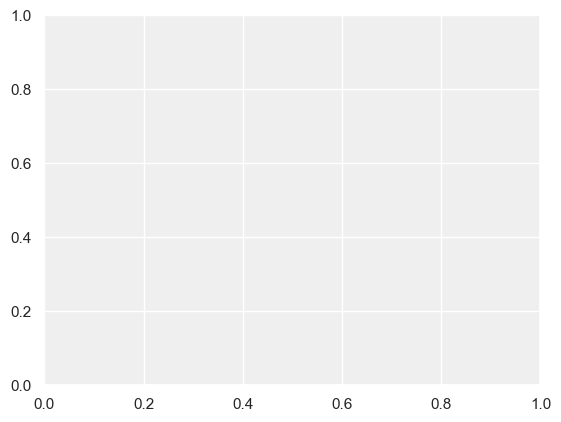

In [71]:
#data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020'
    
# Basic 2D density plot
#sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,hue='user_type2019')
sns.kdeplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.1,alpha=0.6)
plt.title('Los Angeles 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.1,alpha=0.6)
plt.title('Los Angeles 2018/2019 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.1,alpha=0.6)
plt.title('Los Angeles 2019/2020 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()


#sns.kdeplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018')
#sns.kdeplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2019')
#sns.kdeplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020')


LinAlgError: singular matrix

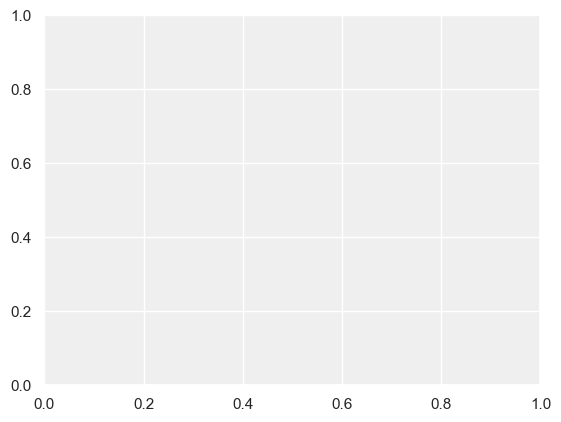

In [70]:
#data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020'
    
# Basic 2D density plot
#sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,hue='user_type2019')
sns.kdeplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('London 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('London 2018/2019 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('London 2019/2020 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()


#sns.kdeplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018')
#sns.kdeplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2019')
#sns.kdeplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020')


### London 2018, 2019 and 2020 in one figure 

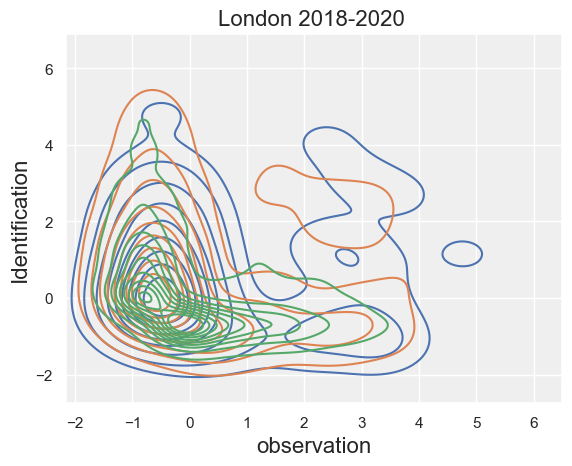

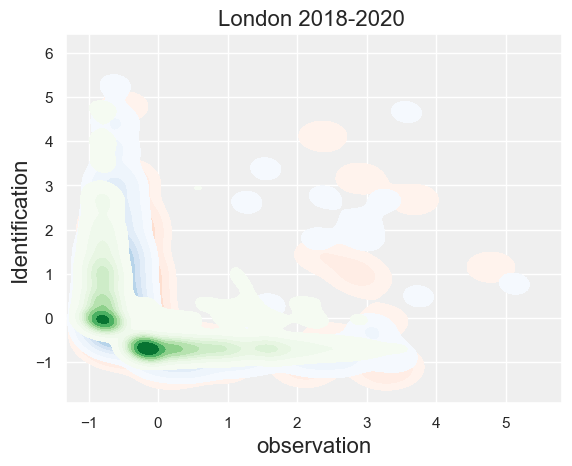

In [71]:
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018 )
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019)
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020)
plt.title('London 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5,label='london 2018')
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5,label='london 2019')
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5,label='london 2020')
plt.title('London 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()


## Different types of User Activity 2018, 2019 and 2020 

In [72]:
#high activity users 2018, 2019, 2020 
higha_2018 = df_std.loc[df_std['user_type2018']=='high activity']
higha_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='high activity']
higha_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='high activity']

In [73]:
#low activity users 2018, 2019, 2020 
lowa_2018 = df_std.loc[df_std['user_type2018']=='low activity']
lowa_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='low activity']
lowa_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='low activity']

In [74]:
#observers 2018, 2019, 2020 
obs_2018 = df_std.loc[df_std['user_type2018']=='observers']
obs_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='observers']
obs_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='observers']

In [75]:
#identifiers 2018, 2019, 2020 
iden_2018 = df_std.loc[df_std['user_type2018']=='identifiers']
iden_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='identifiers']
iden_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='identifiers']

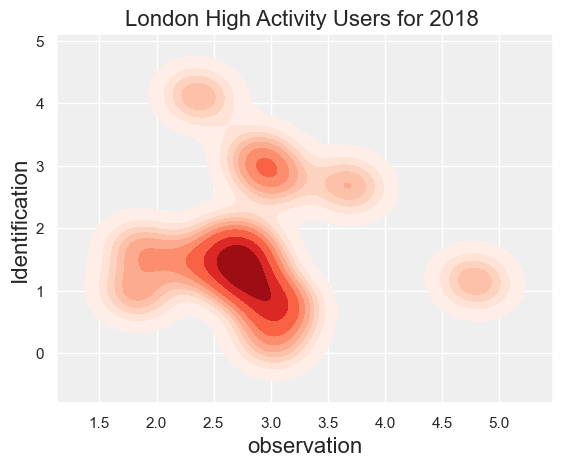

In [76]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
#sns.kdeplot(x=lowa_2018.obs_count_2018, y=lowa_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
#sns.kdeplot(x=obs_2018.obs_count_2018, y=obs_2018.ident_count_2018, cmap="Greens", shade=True, bw_adjust=.5)
#sns.kdeplot(x=iden_2018.obs_count_2018, y=iden_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
plt.title('London High Activity Users for 2018 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

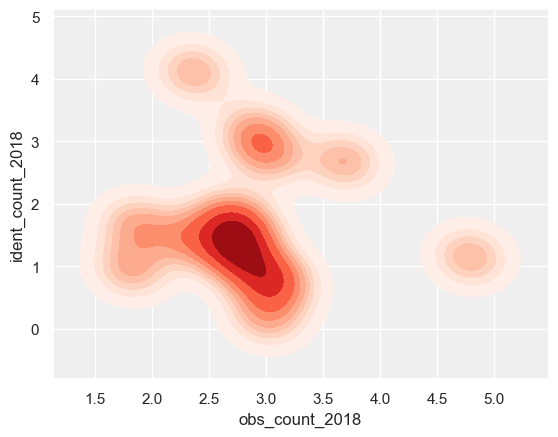

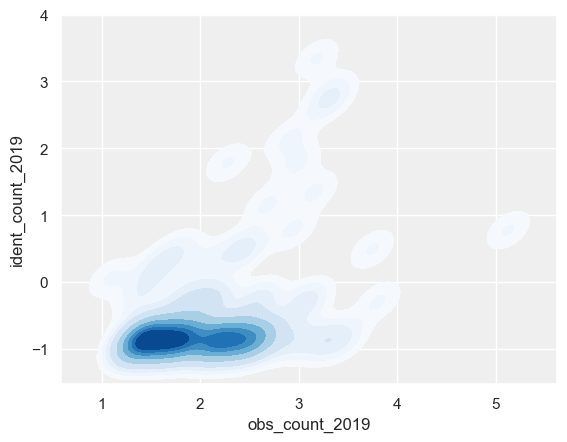

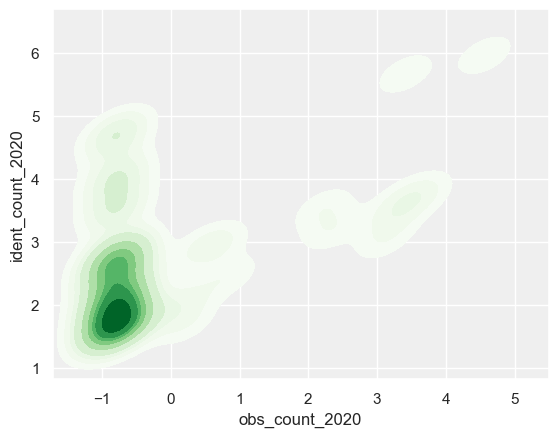

Text(0, 0.5, 'Identification')

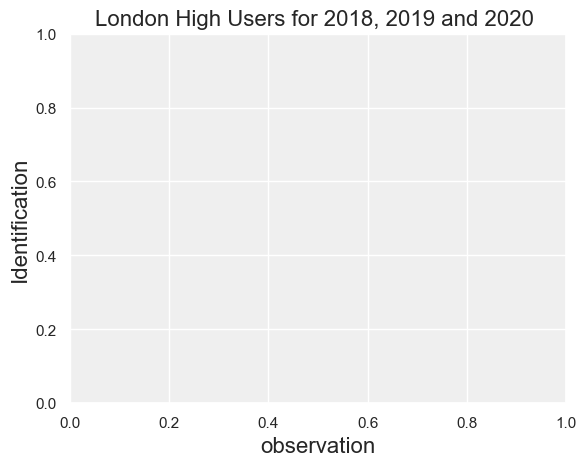

In [77]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2019.obs_count_2019, y=higha_2019.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2020.obs_count_2020, y=higha_2020.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5)
plt.show()
plt.title('London High Users for 2018, 2019 and 2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
#plt.show()

###Test

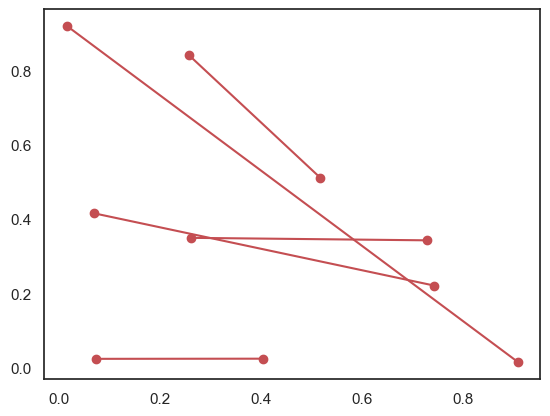

In [61]:
###Test
import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.random(size=(2,10))

for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'ro-')

plt.show()

In [119]:
import plotly.express as px


In [132]:
ax = plt.figure(figsize=(11,9))
ax = px.line(df1, x="obs_count_2018", y="ident_count_2018", color="cluster_2018", text="user_type2018")
ax = px.line(df1, x="obs_count_2019", y="ident_count_2019", color="cluster_2019", text="user_type2018")
fig.update_traces(textposition="bottom right")
fig.show()




<Figure size 1100x900 with 0 Axes>

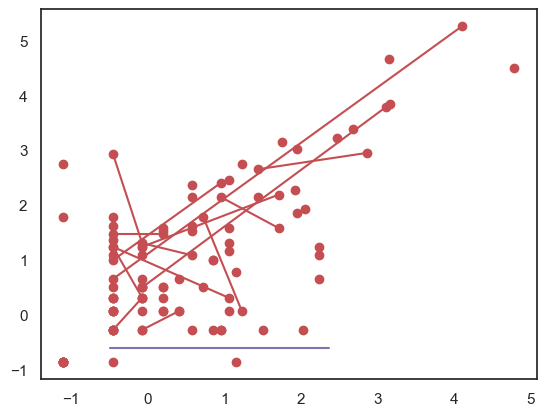

In [117]:
import matplotlib.pyplot as plt
x= df1['obs_count_2018']
y= df1['ident_count_2018']

x1= df1['obs_count_2019']
y1= df1['ident_count_2019']

plt.figure()
for i in range(0, len(x), 2):
    #plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    plt.plot(x[i:i+2], x1[i:i+2],y[i:i+2], y1[i:i+2], 'ro-')
    # Show/save figure as desired.
plt.show()
#plt.show()



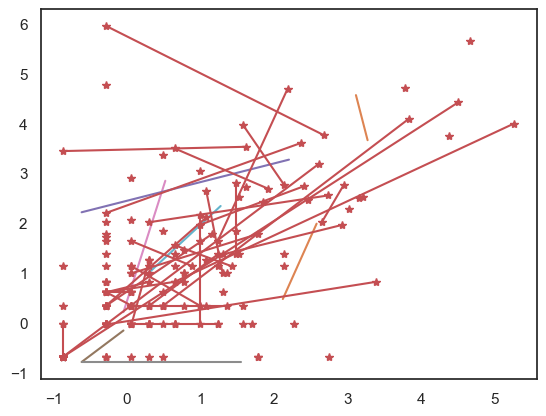

In [118]:
import matplotlib.pyplot as plt
x= df1['obs_count_2019']
y= df1['ident_count_2019']

x1= df1['obs_count_2020']
y1= df1['ident_count_2020']

plt.figure()
for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], x1[i:i+2],y[i:i+2], y1[i:i+2], 'r*-')
    # Show/save figure as desired.
plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()


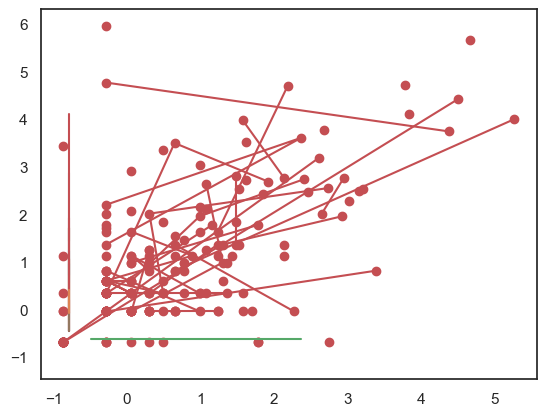

In [113]:
x= df1['obs_count_2018']
y= df1['ident_count_2018']

x1= df1['obs_count_2019']
y1= df1['ident_count_2019']

x2= df1['obs_count_2020']
y2= df1['ident_count_2020']

plt.figure()
for i in range(0, len(x), 3):
    #plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    plt.plot(x[i:i+3], x1[i:i+3],x2[i:i+3],y[i:i+3], y1[i:i+3],y2[i:i+3], 'ro-')
    # Show/save figure as desired.
plt.show()
#plt.show()
